<!-- Title: -->
<div align="center">
  <h1><b> Vanilla NumPy MLP Neural Network with SGD and Backpropagation </b></h1>
</div>
<br>

<div align='center'>
<table class="tfo-notebook-buttons" align="head">
  <td>
    <a target="_blank" href="https://github.com/camponogaraviera/vanilla-numpy-mlp-backprop"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /></a>
  </td>
</table>
</div>

---
**Current features of the neural network:**

- It has two fully connected hidden layers.

- Backpropagation was computed in two ways:
    - Using `MSE` loss function with `Sigmoid` activation function in `both output and hidden layers` for binary or ¹multi-label classification. 
    - Using `Categorical Cross-Entropy` loss function with `Softmax` activation in the `output layer` and `Sigmoid in the hidden layers` for multi-class classification.

- Supports three weight initializations: `xavier`, `he` or `normal`.

- Has option for L2 regularization of the loss function.

- Supports training by batches.

- To monitor the progress of the training epoch, I've implemented a progress bar consisting of dashes, so as to look similar to the functionality provided in Keras.


```python
model = NeuralNetwork(input_layer_size=784, 
                   hidden_layer_size=32, 
                   hidden2_layer_size=64, 
                   output_layer_size=10, 
                   init_method='xavier', 
                   activation='softmax', 
                   learning_rate=0.0001, 
                   loss='cross_entropy',
                   regularization=0.001)

history = model.train(x_train, y_train, x_test, y_test, epochs = 20, batch_size = 1)
```

---
¹Multi-label: when the data have more than one right answer (label), i.e, non-exclusive targets. Multi-class: when the data can belong to only one of all possible classes, i.e, mutually exclusive targets. See the [theory.ipynb](#) for a review.

---

# Table of Contents

- [Importing dependencies.](#dependencies)
- [Utils.](#utils)
- [Creating a dictionary.](#dictionary)
- [Loading and preprocessing the dataset.](#dataset)
    - Reading the dataset.
    - Decoding the dataset.
    - Rescaling the samples.
    - One-hot encoding for labels.
    - [Data augmentation.](#aug)
- [Showing samples.](#show)
- [Activation functions.](#acc)
    - Sigmoid.
    - Softmax.
    - Rectified Linear Unit.
    - Hyperbolic tangent.
- [Loss functions.](#acc)
    - MSE.
    - MSE with L2 regularization.
    - Binary Crossentropy.
    - Categorical Crossentropy.
- [Accuracy function.](#acc)
- [The Backpropagation algorithm.](#backprop)
    - Backpropagation for MSE loss and Sigmoid activation function.
    - Backpropagation for categorical cross-entropy loss and Softmax activation function.
- [Implementation of the MLP ANN.](#implementation)
- [Training.](#training)
    - Plotting loss and Accuracy.
- [Making predictions.](#predictions)

# &nbsp; <a href="#"><img valign="middle" height="45px" src="https://img.icons8.com/python" width="45" hspace="0px" vspace="0px"></a> Importing dependencies

In [1]:
# Function annotation
from typing import List

# Dataset
import sys, csv, os

# Neural Network
import numpy as np

# Plotting
from matplotlib import pyplot as plt

# Utils

In [2]:
def plot_history(history, filename=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the training and validation loss
    ax1.plot(history['loss'], label='Training loss')
    ax1.plot(history['val_loss'], label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot the training and validation accuracy
    ax2.plot(history['accuracy'], label='Training accuracy')
    ax2.plot(history['val_accuracy'], label='Validation accuracy')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Save the plot if a save path is provided
    if filename:
        # Create the "assets" directory if it doesn't exist
        os.makedirs("assets", exist_ok=True)
        save_file = os.path.join("assets", filename)
        plt.savefig(save_file)
        print(f"Plot saved to: {save_file}")

    plt.show()

In [3]:
def display_predictions(X, Y, start=0, num_samples=5, filename=None):
    # Pixel size
    pixel = int(np.sqrt(X.shape[1]))
    # Selecting samples:
    samples = X[start:start+num_samples]
    labels = Y[start:start+num_samples]
    # Creating predictions:
    predictions = model.predict(samples)

    # Create a grid of subplots with a maximum of 5 images per row:
    num_col = 5
    num_rows = (num_samples + 4) // num_col
    _, axes = plt.subplots(num_rows, num_col, figsize=(15, 3*num_rows))
    # Show each image on a separate subplot:
    for i, ax in enumerate(axes.flat):
        if i < num_samples:
            ax.imshow(samples[i].reshape(pixel, pixel))
            ax.set_axis_off()
            ax.set_title(f'Ground Truth: {get_label(labels[i])}\nPrediction: {get_label(predictions[i])}')

    # Save the plot if a save path is provided
    if filename:
        # Create the "assets" directory if it doesn't exist
        os.makedirs("assets", exist_ok=True)
        save_file = os.path.join("assets", filename)
        plt.savefig(save_file)
        print(f"Plot saved to: {save_file}")
        
    plt.show()

In [4]:
def display_random_predictions(X, Y, n=5):
    dataset_size = X.shape[0]
    # Pixel size
    pixel = int(np.sqrt(X.shape[1]))
    for _ in range(n):
        # Index for random sample selection
        index = np.random.randint(0, dataset_size)
        # Reshape a single test sample selected at random
        sample=X[index].reshape(pixel, pixel)
        # Show image
        plt.imshow(sample)
        plt.show()
        print(f'Ground truth: {get_label(Y[index])}')
        prediction = model.predict(sample.reshape(1, -1))
        print(f'Predicted: {get_label(prediction)}')

# Creating a dictionary

In [5]:
label_dict = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal',\
              6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}

def get_label(label_array):
    return label_dict[np.argmax(label_array)] # np.rgmax returns the position of the highest value.

In [6]:
# Testing
get_label([0,0,1,]), get_label(np.random.randint(0, 10, size=10))

('Pullover', 'Trouser')

# Loading and preprocessing the dataset

The steps involved in the following data preprocessing are:

1. Reading: read the dataset from the .csv file.
2. Decoding: decode contents of the dataset and convert it into floating point tensors.
3. Rescaling - Normalizing the tensors of features to [-1, 1] or [0, 1].
4. Encoding labels: one-hot encoding.
5. Data Augmentation.

In [7]:
def preprocessing(filename, n_rows, n_classes):
    '''
    Method for pre-processing the dataset.
    NumPy vectorization: operations are made on the entire array rather than looping over each element.
    '''
    print('Reading dataset...')
    data = np.loadtxt(filename, delimiter=',', skiprows=1) # Read the external dataset file and save it to a numpy array.
    # Placeholder:
    labels = np.zeros((n_rows, n_classes), dtype=np.float32)
    print('Rescaling samples...')
    images = (data[:, 1:] / 255.0) * 2 - 1 # Rescale samples to -1 and 1 using NumPy vectorization technique while skipping the first column.
    print('One-hot encoding...')
    labels[np.arange(n_rows), data[:, 0].astype(int)] = 1 # One-hot encoding by slicing with data[:, 0] because the first column of the dataset contains the labels.
    print('Done!\n')
    return images, labels

In [8]:
x_train, y_train = preprocessing('dataset/fashion-mnist_train.csv', 60000, len(label_dict))
x_test, y_test = preprocessing('dataset/fashion-mnist_test.csv', 10000, len(label_dict))

Reading dataset...
Rescaling samples...
One-hot encoding...
Done!

Reading dataset...
Rescaling samples...
One-hot encoding...
Done!



In [9]:
np.min(x_train), np.max(x_test), np.min(y_train), np.max(y_test)

(-1.0, 1.0, 0.0, 1.0)

In [10]:
x_train.shape, y_train.shape

((60000, 784), (60000, 10))

In [11]:
x_train[:5,:] # Showing the first 5 samples.

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

In [12]:
y_train[:5,:] # Showing the first 5 labels.

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [13]:
label_dict[np.argmax(y_train[-1])] 

'Sneaker'

## Data augmentation

Let's look at three ways to flip an image (array) horizontally, i.e, reversing the elements in a row:

In [14]:
# 1st way:

orig = np.random.normal(0,1,size=(2,2))
flipped = np.empty(orig.shape) 
for row in range(orig.shape[0]): 
    flipped[row,:] = orig[row][::-1]

orig, flipped

(array([[-0.71583044,  0.78553758],
        [ 0.07858859, -0.73153819]]),
 array([[ 0.78553758, -0.71583044],
        [-0.73153819,  0.07858859]]))

In [15]:
# 2nd way:

orig = np.random.normal(0,1,size=(2,2))
flipped = orig.copy()
for row in flipped:
    row[:] = row[::-1]

orig, flipped

(array([[-0.90038704, -0.89113044],
        [-0.0283089 , -0.14757123]]),
 array([[-0.89113044, -0.90038704],
        [-0.14757123, -0.0283089 ]]))

In [16]:
# 3rd way:

orig = np.random.normal(0,1,size=(2,2))
flipped = np.fliplr(orig)
orig, flipped

(array([[ 0.65738377, -0.6896984 ],
        [-1.50384603, -0.11179555]]),
 array([[-0.6896984 ,  0.65738377],
        [-0.11179555, -1.50384603]]))

In [17]:
def flip_image(image):
    '''
    Flips an image horizontally, and vertically.
    
    Args:
        - image (np.ndarray): a numpy array containing a single sample (image).  
    
    Returns:
        - flipped_matrix (list): a list with the flipped matrices.
    '''
    image_matrix = image.reshape((28,28))
    flipped_hor_matrix = np.fliplr(image_matrix)
    flipped_ver_matrix = np.flipud(image_matrix)
    flipped_matrix = [flipped_hor_matrix, flipped_ver_matrix]
    return flipped_matrix

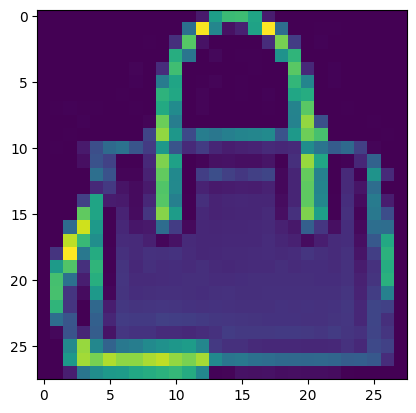

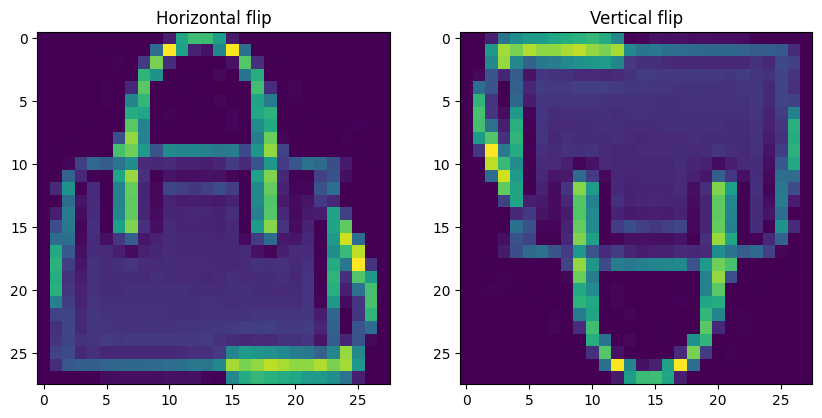

In [18]:
sample = x_train[11].reshape(28,28)
flip_hor, flip_ver = flip_image(sample)

# Show the original image
plt.imshow(sample)
plt.show()

# Show flipped image
_, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(flip_hor)
axes[0].set_title('Horizontal flip')
axes[1].imshow(flip_ver)
axes[1].set_title('Vertical flip')
plt.show()

del sample, flip_hor, flip_ver, _, axes

In [19]:
def augment_dataset(x, y):
    '''
    Augment the old dataset with new images and labels.
    '''
    new_images = np.zeros(x.shape, dtype=x.dtype)
    new_labels = np.zeros(y.shape, dtype=y.dtype)
    for i in range(x.shape[0]):
        flip_hor, flip_ver = flip_image(x[i])
        # Flipping horizontally:
        new_images[i] = flip_hor.reshape((1, x_train.shape[1]))
        # Flipping vertically:
        new_images[i] = flip_ver.reshape((1, x_train.shape[1]))
        new_labels[i] = y[i] 
    # Combine images and labels:
    train_images = np.vstack([x, new_images])
    train_labels = np.vstack([y, new_labels])
    print("Original dataset shapes: x_train={}, y_train={}".format(x.shape, y.shape))
    print("New dataset shapes: x_train={}, y_train={}".format(train_images.shape, train_labels.shape))
    return train_images, train_labels

In [20]:
# Perform data augmentation:

x_train, y_train = augment_dataset(x_train, y_train)

Original dataset shapes: x_train=(60000, 784), y_train=(60000, 10)
New dataset shapes: x_train=(120000, 784), y_train=(120000, 10)


In [21]:
sys.getsizeof(x_train), sys.getsizeof(y_train) 

(752640128, 4800128)

# Showing samples

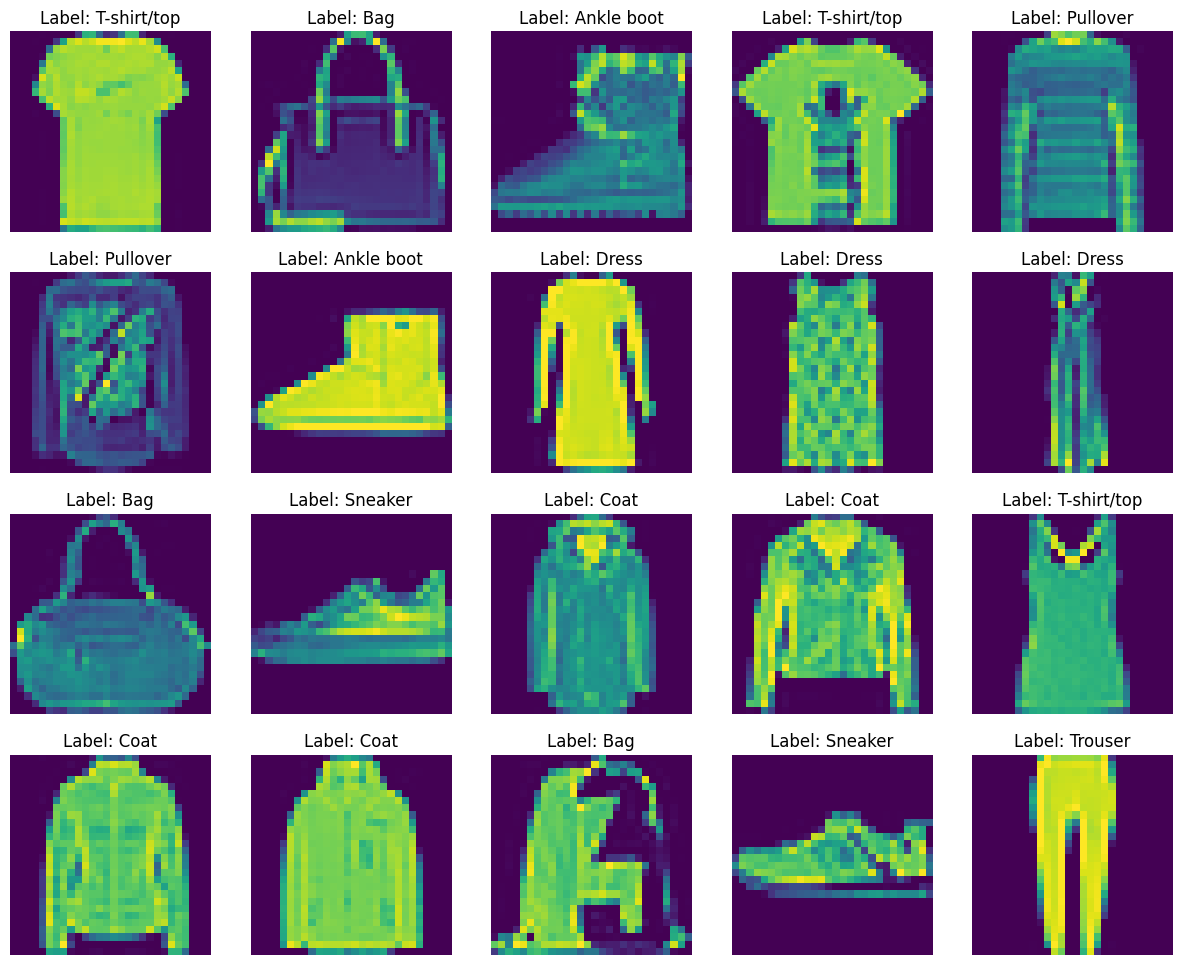

In [22]:
def display_sample(X, Y, start=0, num_samples=5):
    if not num_samples:
        return None
    # Pixel size
    pixel = int(np.sqrt(X.shape[1]))
    # Reshape the first num_samples samples:
    samples = X[start:start+num_samples].reshape(num_samples, pixel, pixel)
    labels = Y[start:start+num_samples]
    # Create a grid of subplots with a maximum of 5 images per row:
    num_col = 5
    num_rows = (num_samples + 4) // num_col
    _, axes = plt.subplots(num_rows, num_col, figsize=(15, 3*num_rows))
    # Show each image on a separate subplot:
    for i, ax in enumerate(axes.flat):
        if i < num_samples:
            ax.imshow(samples[i])
            ax.set_axis_off()
            ax.set_title(f'Label: {get_label(labels[i])}')
    plt.show()

display_sample(x_train, y_train, start=10, num_samples=20)

# Activation functions

- Sigmoid:

\begin{align}
\sigma(x) = \frac{1}{1+e^{-x}}.
\end{align} 

In [23]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    '''
    Applies the sigmoid activation function on input values.

    Args:
      - x (numpy.ndarray): array of values [-infinity, +infinity] from each neuron of a given layer.

    Returns:
      - activation (numpy.ndarray): array of sigmoid activation values in the range [0, 1]. 
                                    Outputs are non-exclusive, i.e, their sum do not add up to 1.
    '''
    return 1.0 / (1 + np.exp(-x))

- Softmax:

\begin{align}
softmax(x_i) = \frac{e^{x_i}}{\sum{e^{x_j}}}.
\end{align} 

A more stable version for NumPy implementation is:

\begin{align}
softmax(x_i) = \frac{\gamma e^{x_i}}{\gamma \sum{e^{x_j}}} = \frac{e^{x_i+ln(\gamma)}}{\sum{e^{x_j+ln(\gamma)}}}.
\end{align} 

A common choice is $ln(\gamma) = -max(x)$.

In [24]:
def softmax(x: np.ndarray) -> np.ndarray:
    '''
    Compute the softmax activation function while handling numerical stability.

    Args:
      - x (numpy.ndarray): array of values in the range [-infinity, +infinity].

    Returns:
      - activation (numpy.ndarray): array of softmax activation values in the range [0, 1].
                                    Outputs are exclusive, i.e, the sum of the values add up to 1.    
    '''
    epsilon = 1e-8 # Small number to avoid division by zero.
    expX = np.exp(x - np.max(x)) # Subtracting the maximum value for numerical stability, avoiding overflow 
                                 # when taking the exp. of large numbers.
    return expX / (np.sum(expX) + epsilon)

In [25]:
# Example usage:

input_ = np.random.rand(1, 10).astype('float32')
output = softmax(input_)
print('Sum of probabilities:',output.sum())

Sum of probabilities: 1.0


In [26]:
input_ = np.array([0,  0])
softmax(input_)

array([0.5, 0.5])

- Hyperbolic tangent:

\begin{align}
tanh(x_i) = \frac{e^{x}-e^{-x}}{e^{x}+e^{-x}} = \frac{e^{2x}-1}{e^{2x}+1}.
\end{align} 

In [27]:
def tanh(x: np.ndarray) -> np.ndarray:
    '''
    Applies the Hyperbolic Tangent activation function on input values.

    Args:
      - x (numpy.ndarray): array of values in the range [-infinity, +infinity] from each neuron of a given layer.

    Returns:
      - activation (numpy.ndarray): array of tanh activation values in the range [-1,1].
    '''
    #return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
    return np.tanh(x)

- Rectified Linear Unit:

\begin{eqnarray}
ReLU(x) = max\{0, x\}.
\end{eqnarray}

In [28]:
def relu(x: np.ndarray) -> np.ndarray:
    '''
    Applies the Rectified Linear Unit (ReLU) activation function on input values.

    Args:
      - x (numpy.ndarray): array of values from each neuron of a given layer.

    Returns:
      - activation (numpy.ndarray): array of relu activation values.
    '''
    return np.maximum(0.0, x)

# Loss functions

## MSE Loss

Mean squared error (MSE) loss function is a non-convex function, i.e, it has more than one minimum, possibly many local minimum.

\begin{eqnarray}
MSE &=& \frac{1}{N}\sum_{i=1}^{N} (\hat{y}_i-y_i)^2.
\end{eqnarray}

Legend:

- $\hat{y}_i$: predicted value for the $i$-th data point (sample).
- $y_i$: ground truth value (label) for the $i$-th data point (sample).
- N: the number of samples in a batch of data.

In [29]:
def mse(y_hat: np.ndarray, y_true: np.ndarray) -> np.float32:
    '''
    Calculates the Mean Squared Error (MSE) loss between the predicted and actual values.

    Args:
      - y_hat (numpy.ndarray): 2D array (num_samples, num_classes) of predicted values.
      - y_true (numpy.ndarray): 2D array (num_samples, num_classes) of ground truth values.

    Returns:
      - loss (numpy.float32): mean squared error loss.
    '''
    err = y_hat - y_true
    loss = np.mean(np.square(err))
    return loss

In [30]:
# Example usage:

y_true = np.array([[0, 1, 0], [0, 0, 1]]) # One-hot encoding.
y_pred = np.array([[0.05, 0.95, 0], [0.1, 0.8, 0.1]])
mse(y_pred, y_true)#.dtype

0.24416667

## MSE Loss with L2 regularization

L2 regularization a.k.a as Ridge Regression is a technique used to deal with overfitting.
Let us use the MSE loss function and add a penalty term (regularization) to it:

\begin{eqnarray}
MSEL2 &=& MSE + \frac{\lambda}{2} \sum_{j=1}^p W^2 \\
&=& \frac{1}{N}\sum_{i=1}^{N} (y_i-\hat{y}_i)^2 + \frac{\lambda}{2} \sum_{j=1}^p (W_j^{(l)})^2.
\end{eqnarray}

Legend:

- $\hat{y}_i$: predicted value for the $i$-th data point (sample).
- $y_i$: ground truth value (label) for the $i$-th data point (sample).
- N: the number of samples in a batch of data.
- $p$ is the number of weight matrices in the neural network.
- $W_j^{(l)}$ is the weight matrix of the $j$-th layer of the neural network.
- $\lambda$ is the regularization term, a value between 0 and 0.1

In [31]:
def mse_l2(y_hat: np.ndarray, y_true: np.ndarray, weights: List[np.ndarray], 
                regularization_coeff: float) -> np.float32:
    '''
    Calculates the Mean Squared Error (MSE) loss with L2 regularization between the predicted and actual values.

    Args:
      - y_hat (numpy.ndarray): 2D array (num_samples, num_classes) of predicted values.
      - y_true (numpy.ndarray): 2D array (num_samples, num_classes) of ground truth values.
      - weights (List[numpy.ndarray]): List of weight matrices in the network (including hidden layers and output layer).
      - regularization_coeff (float): Regularization coefficient (λ or alpha) for L2 regularization.

    Returns:
      - loss (numpy.float32): mean squared error loss with L2 regularization.
    '''
    err = y_hat - y_true
    loss = np.mean(np.square(err))

    regularization_term = 0.0
    for weight_matrix in weights:
        regularization_term += np.sum(np.square(weight_matrix))

    loss += (regularization_coeff / 2) * regularization_term

    return loss.astype(np.float32)

In [32]:
# Example usage:

y_hat = np.array([[0.8, 0.2], [0.6, 0.4]])  # Predicted values.
y_true = np.array([[1.0, 0.0], [0.7, 0.3]]) # Ground truth values.
weights = [np.random.rand(2, 4), np.random.rand(4, 2)]  # Example weight matrices.
regularization_coeff = 0.01

loss = mse_l2(y_hat, y_true, weights, regularization_coeff)
print("MSE Loss with L2 Regularization:", loss)

MSE Loss with L2 Regularization: 0.0511441


## Binary Cross-Entropy Loss

The Binary cross-entropy loss function is the mean average of the binary cross entropy over a batch of data. 

\begin{eqnarray}
BCE_{loss} = \frac{1}{N}\sum_{i=1}^N (BCE)_i = - \frac{1}{N}\sum_{i=1}^N y_i \cdot \mathrm{log}\; {\hat{y}}_i + (1-y_i) \cdot \mathrm{log}\; (1-{\hat{y}}_i).
\end{eqnarray}

Legend:

- $(BCE)_i$: binary cross-entropy value of the $i$-th sample.
- $y_i$: is the actual label (ground truth value) for the $i$-th sample.
- $\hat{y}_i$: is the predicted probability for the positive class of the $i$-th sample.
- $(1-\hat{y}_i)$: is the predicted probability for the negative class of the $i$-th sample.
- $N$: the number of samples in a batch of data.

In binary classification, the output layer of a neural network typically consists of a single neuron with sigmoid activation function or two neurons with softmax activation function. The value of each neuron in the output layer represents the predicted probability of a specific class.

Note: the implementation **does not require target labels to be one-hot encoded**.

## Categorical Cross-Entropy Loss

Categorical cross-entropy is a dissimilarity measure between predicted probability distributions and true labels. It is used in classification tasks with more than two classes. The sum is over all possible classes.

\begin{eqnarray}
CCE &=& -\sum_{i=1}^C y_i \cdot \mathrm{log}\; (\hat{y}_i).
\end{eqnarray}

Legend:

- $log(x)$: is the natural logarithm of $x$.
- $y_i$: is the ground truth value corresponding to class $i$. Either 0 or 1.
- $\hat{y}_i$: is the predicted probability that observation (sample) $\hat{O}$ is of class $i$.
- $C$: number of classes.

Upon expanding the sum, since there is only one non-zero label $y_i$, the equation can be further simplified to:

\begin{eqnarray}
CCE &=& - \mathrm{log}\; (\hat{y}_c),
\end{eqnarray}

where $\hat{y}_c$ is the predicted probability for the correct class.

The categorical cross-entropy loss is the mean average of the categorical cross-entropy function over a batch of data. The summation now is over $N$, the number of samples in the batch.

\begin{eqnarray}
CCE_{loss} &=& -\frac{1}{N}\sum_{i=1}^N (CCE)_i.
\end{eqnarray}

Legend:

- $(CCE)_i$: categorical cross-entropy value of the $i$-th sample.
- $N$: the number of samples in a batch of data.

In multi-class classification, the output layer of a neural network has as many neurons as there are classes and the activation function is typically softmax. The value of each neuron in the output layer represents the predicted probability of a specific class.

Note: in the implementation, **target labels are required to be one-hot encoded**.

In [33]:
def cross_entropy(y_hat: np.ndarray, y_true: np.ndarray) -> np.float32:
    '''
    Computes either the multi-class (categorical) cross-entropy or the binary cross-entropy loss function.
    
    Args:
      - y_hat (numpy.ndarray): 2D array (num_samples, num_classes) of predicted values.
      - y_true (numpy.ndarray): 2D array (num_samples, num_classes) of ground truth values.
      
    Returns:
      - loss (numpy.float64): cross-entropy loss.
    '''
    #y_hat = np.clip(y_hat, epsilon, 1 - epsilon) # Clip y_hat to the range [epsilon, 1 - epsilon].
    epsilon = 1e-8 # Add a small value to y_hat to avoid taking the logarithm of zero.
    if y_true.shape[1] == 2: # Binary cross-entropy:
        loss = -np.mean(y_true * np.log(y_hat) + (1 - y_true) * np.log(1 - y_hat))
    else: # Categorical cross-entropy:
        #n_samples = y_true.shape[0]
        #loss = -np.sum(y_true * np.log(y_hat + epsilon)) / n_samples
        loss = -np.mean(np.sum(y_true * np.log(y_hat + epsilon), axis=1))
    return loss.astype(np.float32)

In [34]:
# Example usage:

y_true = np.array([[0, 1], [1, 0]]) # One-hot encoding.
y_pred = np.array([[0.1, 0.9], [0.9, 0.1]])
print('Binary cross-entropy with two samples:', cross_entropy(y_pred, y_true))

y_true = np.array([[0, 1, 0], [0, 0, 1]]) # One-hot encoding.
y_pred = np.array([[0.05, 0.95, 0], [0.1, 0.8, 0.1]])
print('\nCat. cross-entropy with two samples and three classes:', cross_entropy(y_pred, y_true))

Binary cross-entropy with two samples: 0.105360515

Cat. cross-entropy with two samples and three classes: 1.1769391


# Accuracy function

In [35]:
def compute_accuracy(y_pred: np.ndarray, y_true: np.ndarray) -> np.float64:
    '''
    Calculates the accuracy score of the predicted values.

    Args:
      - y_pred (numpy.ndarray): 2D array (num_samples, num_classes) of predicted values.
      - y_true (numpy.ndarray): 2D array (num_samples, num_classes) of ground truth values.

    Returns:
      - score (numpy.float64): accuracy score of the predicted values.
    '''
    score = np.mean(np.argmax(y_pred, 1) == np.argmax(y_true, 1))
    return score

In [36]:
# Testing accuracy():

y_true = np.array([[0,0,1], [0,1,0]]) # y_true.shape = (2, 3).
y_pred = np.array([[.1,.2,.7], [.1,.2,.7]]) 
compute_accuracy(y_pred, y_true)

assert compute_accuracy(y_pred, y_true) == 0.5, "Test case failed."
print("Test case passed!")

Test case passed!


# The backpropagation algorithm

Resort to the [theory.ipynb](https://github.com/camponogaraviera/vanilla-numpy-mlp-backprop/blob/dev/theory.ipynb) notebook for a full derivation of the backpropagation algorithm for `MSE+Sigmoid` and `CatCrossEntropy+Softmax`.

- Step 1. Use the chain rule to compute the gradient of the loss function which is a composite function of activations and weights.

\begin{align*}
\frac{\partial(\text{loss})}{\partial (\text{weight})} = \frac{\partial \mathcal{L}(z_k(s_k(w_k)))}{\partial w_{j\rightarrow k}^{(l)}} = \frac{\partial \mathcal{L}}{\partial z_k^{(l)}}\frac{\partial z_k^{(l)}}{\partial s_k^{(l)}}\frac{\partial s_k^{(l)}}{\partial w_{j\rightarrow k}^{(l)}}.
\end{align*}

By definition of the weighted sum, the last term is:

\begin{align*}
\frac{\partial s_k}{\partial w_{j\rightarrow k}^{(l)}} = \frac{\partial}{\partial w_{j\rightarrow k}^{(l)}}\left(\sum_{j=0}^{N-1} w_{j \rightarrow k}^{(l)} z_j^{(l-1)}+b_k^{(L)} \right) = z_j^{(l-1)} \frac{\partial}{\partial w_{j\rightarrow k}^{(l)}} \sum_{j=0}^{N-1} w_{j \rightarrow k}^{(l)} = z_j^{(l-1)}.
\end{align*}

With that:

\begin{align*}
\frac{\partial \mathcal{L}(z_k(s_k(w_k)))}{\partial w_{j\rightarrow k}^{(l)}} =  \left(\frac{\partial \mathcal{L}}{\partial z_k^{(l)}}\frac{\partial z_k^{(l)}}{\partial s_k^{(l)}} \right) z_k^{(l-1)} := \delta_j^{(l)} \cdot z_j^{(l-1)}.
\end{align*}

- Step 1.1 Compute $\delta_k$ for node $k$ in output layer $L$:

$$\delta_k = \left(\frac{\partial \mathcal{L}}{\partial z_{k}^{(L)}}\right)\left(\frac{\partial z_k^{(L)}}{\partial s_{k}^{(L)}}\right).$$

- Step 1.2 Compute $\delta_j$ for node $j$ in hidden layer $l$:

$$\delta_j = \left(\frac{\partial \mathcal{L}}{\partial z_j^{(l)}}\frac{\partial z_j^{(l)}}{\partial s_j^{(l)}} \right).$$

- Step 2. Update weights via Gradient Descent (GD) with learning rate $\eta$:

$$w_{j+1} = w_j - \eta \frac{\partial \mathcal{L}}{\partial w_{i\rightarrow j}^{(l)}} = w_j - \eta (\delta_j^l \cdot z_j^{(l-1)}).$$

- Step 3. Update biases via Gradient Descent (GD) with learning rate $\eta$:

$$b_{j+1} = b_j -  \eta \frac{\partial \mathcal{L}}{\partial b_{j}^{(l)}} = b_j - \eta \delta_j^l.$$

# Implementation of the MLP ANN

This implementation uses the following gradients for the backpropagation algorithm. See the [theory.ipynb](#) for a full derivation.

- Output layer

If Sigmoid is used, then:

$$\frac{\partial \mathcal{L}(z_k(s_k(w_k)))}{\partial w_{j\rightarrow k}} = \delta_k^{(L)} z_k^{(L-1)} = (z_k^{(L)} - y_k)z_k^{(L)}(1-z_k^{(L)})z_k^{(L-1)}.$$

If Softmax is used, then:

$$\frac{\partial \mathcal{L}(z_k(s_k(w_k)))}{\partial w_{j\rightarrow k}} = \delta_k^{(L)} z_k^{(L-1)} = (z_k^{(L)}-y_k) z_k^{(L-1)}.$$

- Hdden layers

Only Sigmoid activation is used in the hidden layers:

\begin{align*}
\frac{\partial \mathcal{L}(z_j(s_j(w_j)))}{\partial w_{i\rightarrow j}} =\delta_j z_j^{(l-1)}=\left(\sum_{k \in l=1}^N \delta_k^{(l+1)} w_{j\rightarrow k}\right) z_{j}^{(l)}(1-z_{j}^{(l)})z_j^{(l-1)}.
\end{align*}

Creating a multilayer perceptron (MLP), i.e, a **fully connected** **feedforward** artificial neural network (ANN). Fully connected means that each neuron in the previous layer is connected to every neuron in the current layer.

In [37]:
class NeuralNetwork:
    '''
    The class for the neural network model.
    
    Parameters:
    -----------
    input_layer_size : int, default=784
        The number of neurons in the input layer corresponding to the number of features of the sample.
        
    hidden_layer_size : int, default=20
        The number of neurons in the first hidden layer.
        
    hidden2_layer_size : int, default=20
        The number of neurons in the second hidden layer.
        
    output_layer_size : int, default=10
        The number of neurons in the output layer corresponding to the number of classes.
        
    init_method : str, default='normal'
        The weight initialization method. Possible values: 'xavier', 'he' or 'normal'.
        
    activation : str, default='softmax'
        The activation function used in the output layer. Possible values: 'sigmoid', 'softmax'.
        
    learning_rate : float, default=0.01
        The learning rate used in backpropagation.
        
    loss : str, default='cross_entropy'
        The loss function used to calculate the error. Possible values: 'cross_entropy' or 'mse'.
        
    regularization : float, default=0.0
        The L2 regularization strength. Must be a value between 0 and 0.1.
    '''
    def __init__(self, input_layer_size=28*28, hidden_layer_size=20, hidden2_layer_size=20, 
                 output_layer_size=10, init_method='normal', activation='softmax', 
                 learning_rate=0.01, loss='cross_entropy', regularization=0.0):
        # Hyperparameters
        self.input_layer_size = input_layer_size
        self.hidden_layer_size = hidden_layer_size
        self.hidden2_layer_size = hidden2_layer_size
        self.output_layer_size = output_layer_size
        self.init_method = init_method
        self.activation = activation
        self.learning_rate = learning_rate
        self.loss=loss
        self.regularization = regularization
        # Weights:
        self.Wh, self.Wh2, self.Wo = self.initialize_weights()
        # Biases:
        self.bh, self.bh2, self.bo = self.initialize_biases()
        
    def initialize_weights(self):
        '''
        Computing the matrix of synapses (weights) between fully connected layers.
        This method uses `Xavier`, `He` or `normal` initialization for the weights.
        Here, `normal` is the standard normal distribution with mean of 0 and a standard deviation of 1.
        
        Returns:
            - self.Wh (numpy.ndarray): two-dimensional array of weights connecting input layer to 1st hidden layer.
            - self.Wh2 (numpy.ndarray): two-dimensional array of weights connecting 1st hidden layer to 2nd hidden layer.
            - self.Wo (numpy.ndarray): two-dimensional array of weights connecting 2nd hidden layer to output layer.
        '''
        factor_dict = {
            'xavier': [np.sqrt(2/(self.input_layer_size + self.hidden_layer_size)),
                       np.sqrt(2/(self.hidden_layer_size + self.hidden2_layer_size)),
                       np.sqrt(2/(self.hidden2_layer_size + self.output_layer_size))],
            'he': [np.sqrt(2/self.input_layer_size),
                   np.sqrt(2/self.hidden_layer_size),
                   np.sqrt(2/self.hidden2_layer_size)],
            'normal': [1,1,1]
        }
        if self.init_method not in factor_dict:
            raise ValueError("Invalid initialization method. Allowed values are 'xavier', 'he', or 'normal'.")
        factors = factor_dict[self.init_method]
        self.Wh = np.random.randn(self.input_layer_size, self.hidden_layer_size) * factors[0]
        self.Wh2 = np.random.randn(self.hidden_layer_size, self.hidden2_layer_size) * factors[1]
        self.Wo = np.random.randn(self.hidden2_layer_size, self.output_layer_size) * factors[2]
        return self.Wh, self.Wh2, self.Wo

    def initialize_biases(self):
        '''
        Computing the bias term for each layer. The number of bias in a layer equals the number of neurons.
        Number of trainable parameters in the bias layer: 1*number_of_neurons in the layer.
        
        Returns:
            - self.bh (numpy.ndarray): two-dimensional array (1, layer_size) of bias terms in the 1st hidden layer.
            - self.bh2 (numpy.ndarray): two-dimensional array (1, layer_size) of bias terms in the 2nd hidden layer.
            - self.bo (numpy.ndarray): two-dimensional array (1, layer_size) of bias terms in the 3rd hidden layer.
        '''
        self.bh = np.zeros((1, self.hidden_layer_size))
        self.bh2 = np.zeros((1, self.hidden2_layer_size))
        self.bo = np.zeros((1, self.output_layer_size))
        return self.bh, self.bh2, self.bo

    def compute_loss(self, y_pred: np.ndarray, y_true: np.ndarray) -> np.float32:
        '''
        Compute the mse, mse with L2 or cross-entropy loss function.
        
        Args:
            - y_pred (numpy.ndarray): two-dimensional array (num_samples, num_classes) of predicted values.
            - y_true (numpy.ndarray): two-dimensional array (num_samples, num_classes) of ground truth values.
            
        Returns:
            - loss (numpy.float32): loss value.        
        '''
        loss_functions = {'cross_entropy': cross_entropy, 'mse': mse, 'mse_l2': mse_l2}
        if self.loss not in loss_functions:
            raise ValueError(f"Provide either 'mse', 'mse_l2' or 'cross_entropy' for the loss function.")
        if self.loss == 'mse_l2':
            loss = loss_functions[self.loss](y_pred, y_true, [self.Wo, self.Wh2, self.Wh], self.regularization)
        else:
            loss = loss_functions[self.loss](y_pred, y_true)
                
        return loss.astype(np.float32)

    def forward_pass(self, x):
        '''
        Compute a single feed forward pass through the neural network.
        
        Args:
            - x (numpy.ndarray): two-dimensional array (num_samples, num_features) of input values to the network.
          
        Returns:
            - self.zo (numpy.ndarray): two-dimensional array (num_samples, num_classes) of activation values 
                                       from the output layer, i.e, weighted sum of the inputs from the previous 
                                       layers.        
        '''
        #print(x.shape)
        activations = {'sigmoid': sigmoid, 'softmax': softmax}
        # Getting activation from dict. using the .get() method since activations could be None:
        activation = activations.get(self.activation) 
        if not activation:
            raise ValueError("Provide either 'sigmoid' or 'softmax' for the final activation.")
        self.sh = np.dot(x, self.Wh) + self.bh # Array of input nodes in the 1st layer.
        #print(self.sh.shape)
        self.zh = sigmoid(self.sh) # Array of activation values from the 1st hidden layer.
        self.sh2 = np.dot(self.zh, self.Wh2) + self.bh2 # Sinapse from hidden1 to hidden2.
        #print(self.sh2.shape)
        self.zh2 = sigmoid(self.sh2) # Array of activation values from the 2nd hidden layer.
        self.so = np.dot(self.zh2, self.Wo) + self.bo # Sinapse of output layer.
        #print(self.so.shape)
        self.zo = activation(self.so) # Array of activation values from the output layer.
        return self.zo

    def predict(self, x):
        '''
        Method for making predictions by computing forward passes through the neural network.
        
        Args:
            - x (numpy.ndarray): two-dimensional array (num_samples, num_features) of input values to the network.
            
        Returns:
            - preds (numpy.ndarray): a two-dimensional array (num_samples, num_classes) of predicted values (label).
        '''
        # If 'x' is a single input sample:
        if x.shape[0] == 1:
            preds = self.forward_pass(x) # preds.shape = (1, num_classes).
        else:
            # Computing predictions for a batch of input samples by looping over each element of 'x' with 
            # list comprehension and using np.array() to convert the list of predictions to a 3D numpy array:
            preds = np.array([self.forward_pass(i) for i in x]) # preds.shape = (num_samples, sequence_length=1, num_classes).
            # Reshaping the 3D numpy array into a 2D numpy array:
            preds = preds.reshape((preds.shape[0], preds.shape[2])) # preds.shape = (num_samples, num_classes).
        return preds 

    def train(self, input_train, target_train, input_val, target_val, epochs, batch_size):
        '''
        Method to train the neural network by batches.

        Returns:
            - history (dict): dictionary containing losses and accuracies.
        '''
        n_samples = int(input_train.shape[0])
        num_passes = int(n_samples/batch_size) # Number of passes in one epoch.
        history = dict(loss=[], val_loss=[], accuracy=[], val_accuracy=[])
        for epoch in range(epochs):
            loss = 0.0
            accuracy = 0.0
            print(f'\rEpoch {epoch + 1}/{epochs} ', end='')
            current_pass = 1
            for batch_start in range(0, n_samples, batch_size): # Reading in batches.
                # Progress display: print a dash for every 10% of the number of passes.
                if current_pass % int(0.1*num_passes) == 0:
                    print("-", end=" ")
                current_pass+=1
                batch_end = batch_start + batch_size
                # Reading one batch at a time using slicing [batch_start:batch_end, :] operation:
                x_batch = input_train[batch_start:batch_end, :]
                y_batch = target_train[batch_start:batch_end, :] # Ground-truth values (labels).
                # Forward pass:
                self.forward_pass(x_batch)
                # Loss:
                loss += self.compute_loss(self.zo, y_batch) 
                accuracy += compute_accuracy(self.zo, y_batch)
                # Backpropagation:
                self.backpropagation(x_batch, y_batch)
            # Evaluate model on training data:
            train_loss = loss / num_passes 
            train_accuracy = accuracy / num_passes 
            # Evaluate model on validation data:
            val_preds = self.predict(input_val)
            val_loss = self.compute_loss(val_preds, target_val)
            val_accuracy = compute_accuracy(val_preds, target_val)
            # History:
            history['loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['accuracy'].append(train_accuracy)
            history['val_accuracy'].append(val_accuracy)
            print(f"\rEpoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | "
                  f"Train Accuracy: {train_accuracy:.2%} | Val Loss: {val_loss:.4f} | "
                  f"Val Accuracy: {val_accuracy:.2%}\n", end="")
        return history
    
    def backpropagation(self, x: np.ndarray, y: np.ndarray):
        '''
        Compute the backpropagation algorithm for either MSE loss with Sigmoid or Cross-Entropy loss with Softmax.

        Args:
            - x (numpy.ndarray): two-dimensional array (num_samples, num_features) of training input data.
            - y (numpy.ndarray): a two-dimensional array (num_samples, num_classes) of labels.

        Returns:
            - None.
        '''
        #--------Deltas--------#
        if self.loss in ['mse', 'mse_l2'] and self.activation == 'sigmoid':
            ## Output layer: (Z_𝑘−Y_𝑘)Z_𝑘(1−Z_𝑘)
            self.deltao = (self.zo - y) * self.zo * (1 - self.zo) 
        elif self.loss == 'cross_entropy' and self.activation == 'softmax':
            ## Output layer: (Z_𝑘−Y_𝑘)
            self.deltao = (self.zo - y) 
            
        ## Hidden layers: (∑𝛿_k W_{j→k}) Z_j(1−Z_j)
        self.deltah2 = np.dot(self.deltao, self.Wo.transpose()) * self.zh2 * (1 - self.zh2)
        self.deltah = np.dot(self.deltah2, self.Wh2.transpose()) * self.zh * (1 - self.zh)
        
        #--------L2 Reg--------# 
        dL2_Wo = self.regularization * self.Wo
        dL2_Wh2 = self.regularization * self.Wh2
        dL2_Wh = self.regularization * self.Wh
        
        #----Update weights----# W_𝑘−𝜂(𝛿_𝑘⋅z_{𝑘−1}).
        self.Wo -= self.learning_rate * (np.dot(self.zh2.transpose(), self.deltao) + dL2_Wo)
        self.Wh2 -= self.learning_rate * (np.dot(self.zh.transpose(), self.deltah2) + dL2_Wh2)
        self.Wh -= self.learning_rate * (np.dot(x.transpose(), self.deltah) + dL2_Wh)
        
        #-----Update biases----#
        #self.bo -= self.learning_rate * np.mean(self.deltao, axis=0) 
        #self.bh2 -= self.learning_rate * np.mean(self.deltah2, axis=0)
        #self.bh -= self.learning_rate * np.mean(self.deltah, axis=0)
        self.bo = np.subtract(self.bo, self.learning_rate * np.sum(self.deltao, axis=0))
        self.bh2 = np.subtract(self.bh2, self.learning_rate * np.sum(self.deltah2, axis=0))
        self.bh = np.subtract(self.bh, self.learning_rate * np.sum(self.deltah, axis=0))

In [38]:
# Testing NeuralNetwork class with only one sample:

#input_ = x_train[:2,:].reshape(2, -1) # Shape = (2, 784). First two samples.
input_ = x_train[-1,:].reshape(1, -1)  # Shape = (1, 784). Last sample.
input_layer_size = input_.shape[1]     # 784.
output_layer_size = y_train.shape[1]        # 10.

prediction = NeuralNetwork(input_layer_size, 10, 20, output_layer_size).predict(input_)
prediction.shape

(1, 10)

# Training

This is a multi-class classification problem and, therefore, the most suitable choices are `Categorical Cross-Entropy` as the loss function and `Softmax` as the activation function in the final layer. For comparison, training with `MSE` and `Sigmoid` was also computed.

- Sigmoid and MSE:

In [45]:
model = NeuralNetwork(input_layer_size=784, 
                   hidden_layer_size=70, 
                   hidden2_layer_size=40, 
                   output_layer_size=10, 
                   init_method='he', 
                   activation='sigmoid', 
                   learning_rate=0.001, 
                   loss='mse')

history = model.train(x_train, y_train, x_test, y_test, epochs = 50, batch_size = 100)

Epoch 1/50 | Train Loss: 0.0825 | Train Accuracy: 42.35% | Val Loss: 0.0717 | Val Accuracy: 53.88%
Epoch 2/50 | Train Loss: 0.0626 | Train Accuracy: 61.78% | Val Loss: 0.0572 | Val Accuracy: 63.57%
Epoch 3/50 | Train Loss: 0.0508 | Train Accuracy: 68.50% | Val Loss: 0.0485 | Val Accuracy: 68.56%
Epoch 4/50 | Train Loss: 0.0437 | Train Accuracy: 71.64% | Val Loss: 0.0433 | Val Accuracy: 70.97%
Epoch 5/50 | Train Loss: 0.0395 | Train Accuracy: 73.71% | Val Loss: 0.0402 | Val Accuracy: 72.59%
Epoch 6/50 | Train Loss: 0.0368 | Train Accuracy: 75.27% | Val Loss: 0.0380 | Val Accuracy: 74.02%
Epoch 7/50 | Train Loss: 0.0348 | Train Accuracy: 76.50% | Val Loss: 0.0362 | Val Accuracy: 75.34%
Epoch 8/50 | Train Loss: 0.0333 | Train Accuracy: 77.52% | Val Loss: 0.0347 | Val Accuracy: 76.42%
Epoch 9/50 | Train Loss: 0.0321 | Train Accuracy: 78.29% | Val Loss: 0.0335 | Val Accuracy: 77.38%
Epoch 10/50 | Train Loss: 0.0311 | Train Accuracy: 78.97% | Val Loss: 0.0324 | Val Accuracy: 78.11%
Epoch 11/

- Plotting loss and Accuracy:

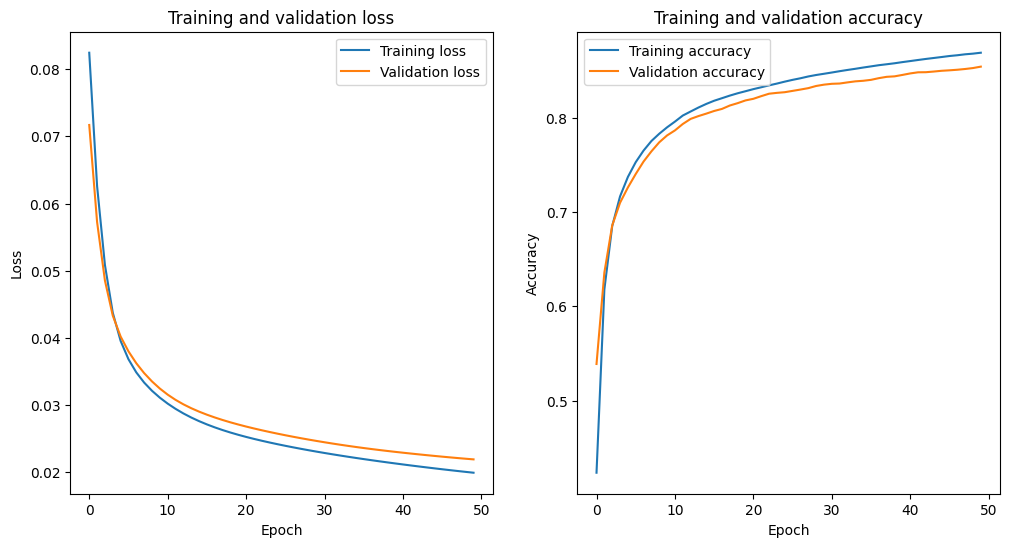

In [46]:
plot_history(history)

- Sigmoid and MSE_L2:

In [47]:
model = NeuralNetwork(input_layer_size=784, 
                   hidden_layer_size=70, 
                   hidden2_layer_size=40, 
                   output_layer_size=10, 
                   init_method='he', 
                   activation='sigmoid', 
                   learning_rate=0.001, 
                   loss='mse_l2',
                   regularization=0.0001)

history = model.train(x_train, y_train, x_test, y_test, epochs = 50, batch_size = 100)

Epoch 1/50 | Train Loss: 0.0937 | Train Accuracy: 39.95% | Val Loss: 0.0829 | Val Accuracy: 51.03%
Epoch 2/50 | Train Loss: 0.0755 | Train Accuracy: 58.90% | Val Loss: 0.0721 | Val Accuracy: 61.86%
Epoch 3/50 | Train Loss: 0.0667 | Train Accuracy: 66.83% | Val Loss: 0.0660 | Val Accuracy: 67.08%
Epoch 4/50 | Train Loss: 0.0618 | Train Accuracy: 70.22% | Val Loss: 0.0628 | Val Accuracy: 69.86%
Epoch 5/50 | Train Loss: 0.0593 | Train Accuracy: 72.88% | Val Loss: 0.0611 | Val Accuracy: 72.24%
Epoch 6/50 | Train Loss: 0.0578 | Train Accuracy: 74.77% | Val Loss: 0.0598 | Val Accuracy: 74.12%
Epoch 7/50 | Train Loss: 0.0569 | Train Accuracy: 76.02% | Val Loss: 0.0589 | Val Accuracy: 75.14%
Epoch 8/50 | Train Loss: 0.0563 | Train Accuracy: 77.05% | Val Loss: 0.0583 | Val Accuracy: 76.00%
Epoch 9/50 | Train Loss: 0.0560 | Train Accuracy: 77.87% | Val Loss: 0.0580 | Val Accuracy: 76.69%
Epoch 10/50 | Train Loss: 0.0560 | Train Accuracy: 78.44% | Val Loss: 0.0579 | Val Accuracy: 77.48%
Epoch 11/

- Plotting loss and Accuracy:

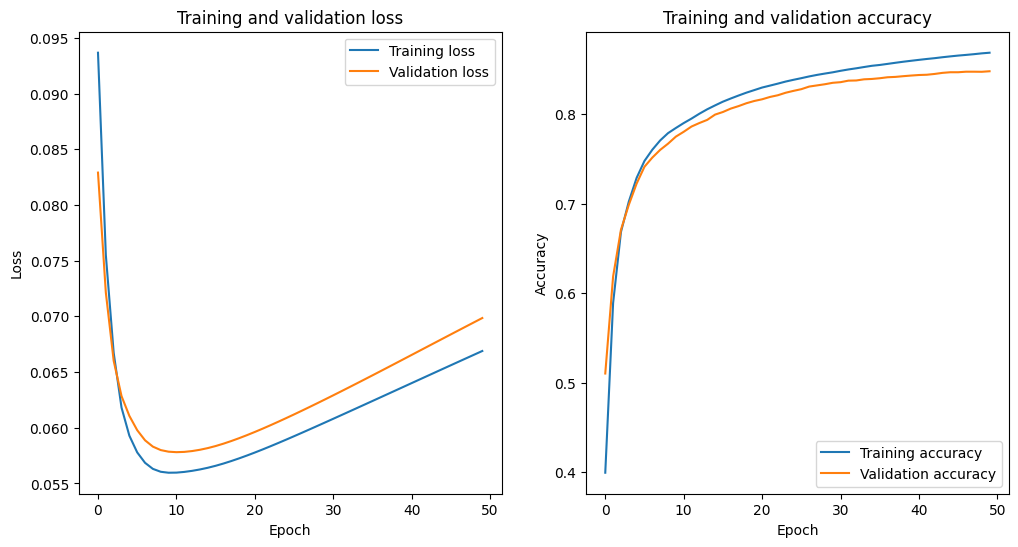

In [48]:
plot_history(history)

- Softmax and Categorical Cross Entropy:

In [51]:
model = NeuralNetwork(input_layer_size=784, 
                   hidden_layer_size=32, 
                   hidden2_layer_size=64, 
                   output_layer_size=10, 
                   init_method='xavier', 
                   activation='softmax', 
                   learning_rate=0.0001, 
                   loss='cross_entropy')

history = model.train(x_train, y_train, x_test, y_test, epochs = 50, batch_size = 1)

Epoch 1/50 | Train Loss: 2.1052 | Train Accuracy: 39.07% | Val Loss: 1.8747 | Val Accuracy: 44.34%
Epoch 2/50 | Train Loss: 1.6443 | Train Accuracy: 48.57% | Val Loss: 1.4720 | Val Accuracy: 52.06%
Epoch 3/50 | Train Loss: 1.3424 | Train Accuracy: 56.91% | Val Loss: 1.2592 | Val Accuracy: 59.80%
Epoch 4/50 | Train Loss: 1.1768 | Train Accuracy: 61.41% | Val Loss: 1.1314 | Val Accuracy: 62.97%
Epoch 5/50 | Train Loss: 1.0652 | Train Accuracy: 64.20% | Val Loss: 1.0373 | Val Accuracy: 65.56%
Epoch 6/50 | Train Loss: 0.9779 | Train Accuracy: 66.97% | Val Loss: 0.9617 | Val Accuracy: 68.33%
Epoch 7/50 | Train Loss: 0.9069 | Train Accuracy: 69.58% | Val Loss: 0.8998 | Val Accuracy: 70.57%
Epoch 8/50 | Train Loss: 0.8491 | Train Accuracy: 71.27% | Val Loss: 0.8492 | Val Accuracy: 71.89%
Epoch 9/50 | Train Loss: 0.8024 | Train Accuracy: 72.44% | Val Loss: 0.8081 | Val Accuracy: 72.84%
Epoch 10/50 | Train Loss: 0.7649 | Train Accuracy: 73.29% | Val Loss: 0.7746 | Val Accuracy: 73.47%
Epoch 11/

Plot saved to: assets/training_plot.png


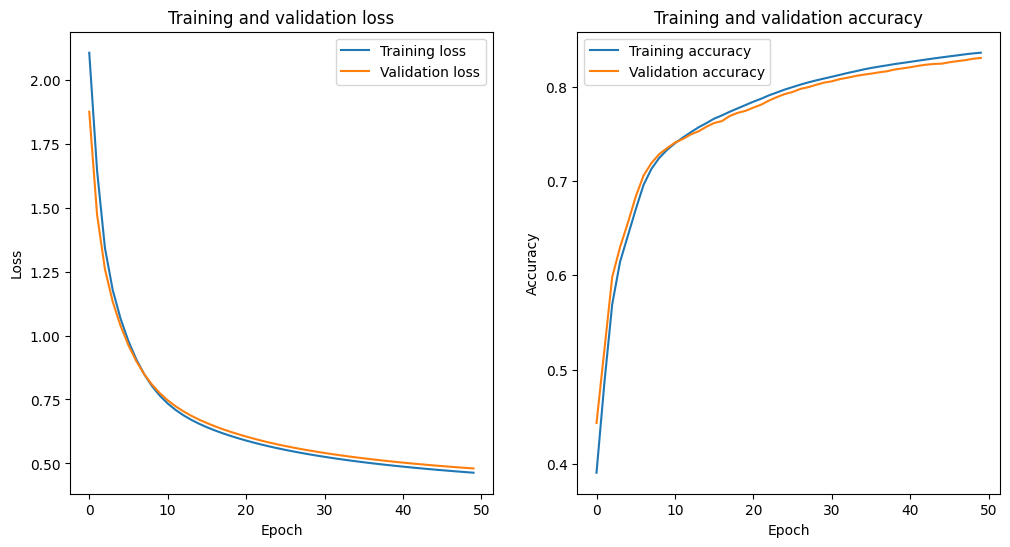

In [52]:
plot_history(history, filename="training_plot.png")

# Making predictions

Plot saved to: assets/predictions.png


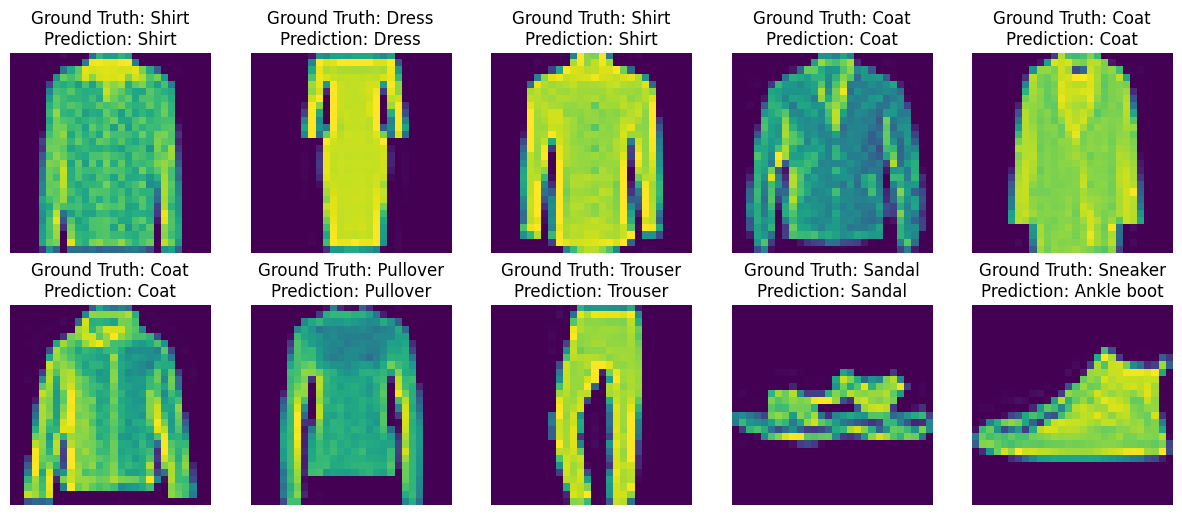

In [54]:
display_predictions(x_test, y_test, start=16, num_samples=10, filename='predictions.png')

## Random predictions:

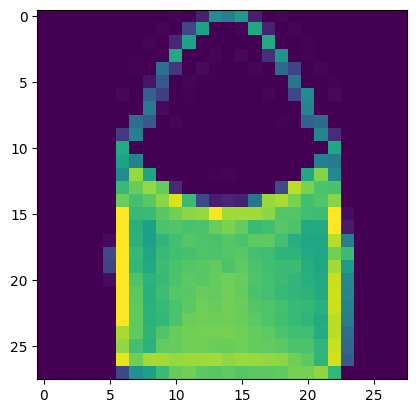

Ground truth: Bag
Predicted: Bag


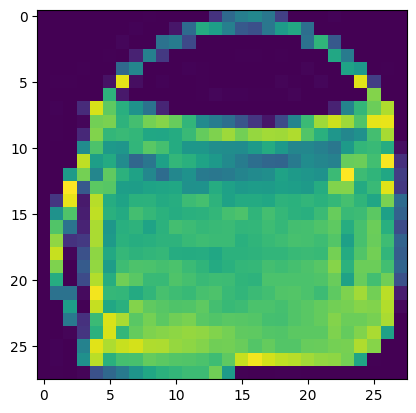

Ground truth: Bag
Predicted: Bag


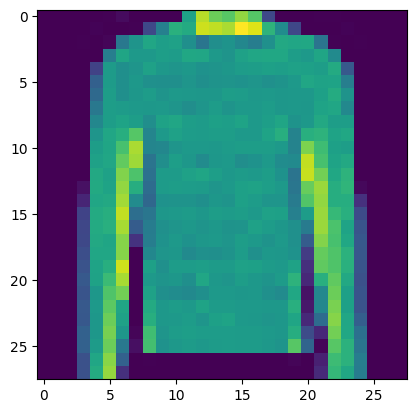

Ground truth: Pullover
Predicted: Pullover


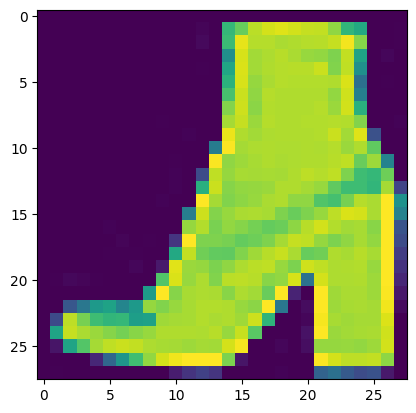

Ground truth: Ankle boot
Predicted: Ankle boot


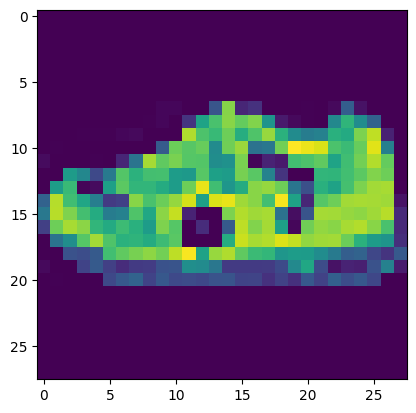

Ground truth: Sneaker
Predicted: Sneaker


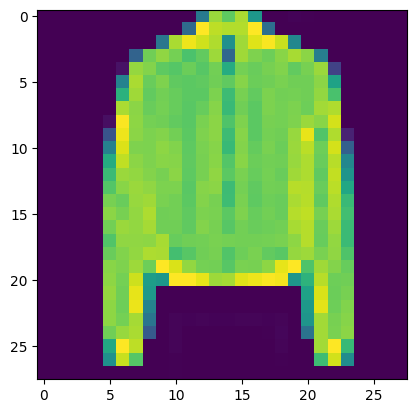

Ground truth: Coat
Predicted: Coat


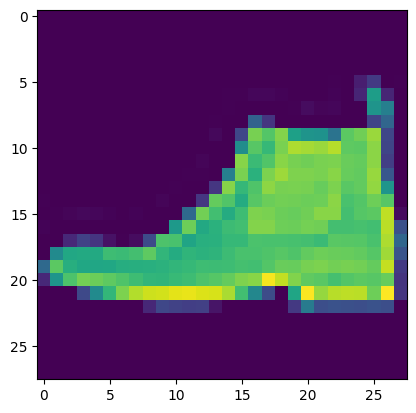

Ground truth: Ankle boot
Predicted: Ankle boot


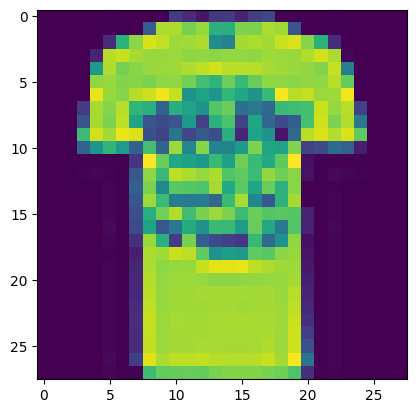

Ground truth: T-shirt/top
Predicted: T-shirt/top


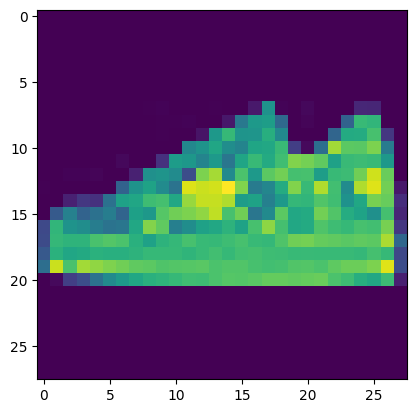

Ground truth: Sneaker
Predicted: Sneaker


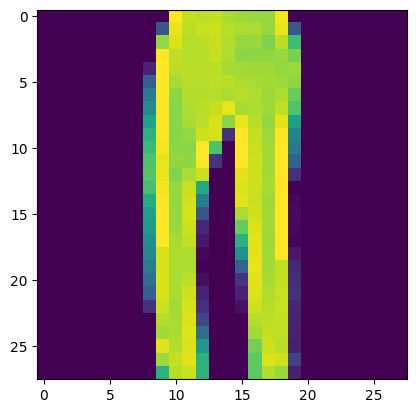

Ground truth: Trouser
Predicted: Trouser


In [55]:
display_random_predictions(x_test, y_test, 10)